<a href="https://colab.research.google.com/github/rohitha077/CODSOFT/blob/main/task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generated 100 dummy samples.
Vocabulary size: 23
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Extracting features from dummy images...
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step
Features extracted.
Training the model...
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - loss: 1.7229
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 1.6624
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - loss: 1.6430
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - loss: 1.6225
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - loss: 1.6102
Training complete.

--- Example Caption Generation ---
Generating caption for 'dummy_test_image.jpg'...
Generated Caption: cat cat cat house big big


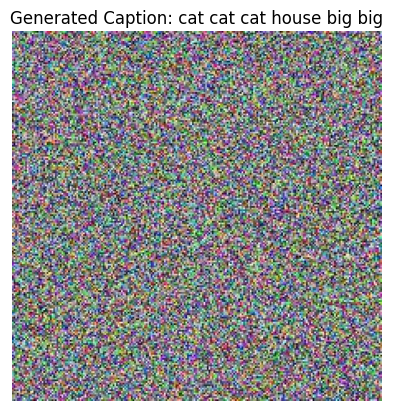

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import collections
import matplotlib.pyplot as plt
from PIL import Image

IMAGE_SIZE = (224, 224)
VOCAB_SIZE = 5000
MAX_CAPTION_LENGTH = 20
EMBEDDING_DIM = 256
LSTM_UNITS = 512
BATCH_SIZE = 32
EPOCHS = 5

def generate_dummy_data(num_samples=100):
    dummy_images = []
    dummy_captions = []
    word_to_idx = {'<start>': 0, '<end>': 1, '<pad>': 2}
    idx_to_word = {0: '<start>', 1: '<end>', 2: '<pad>'}
    current_idx = 3

    for _ in range(num_samples):
        dummy_images.append(np.random.rand(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    dummy_words = ['apple', 'banana', 'cat', 'dog', 'house', 'tree', 'sun', 'moon', 'car', 'flower', 'is', 'a', 'the', 'on', 'in', 'with', 'big', 'small', 'red', 'blue']
    for i in range(num_samples):
        num_words = np.random.randint(3, MAX_CAPTION_LENGTH - 2)
        caption = ['<start>']
        for _ in range(num_words):
            word = np.random.choice(dummy_words)
            caption.append(word)
            if word not in word_to_idx:
                word_to_idx[word] = current_idx
                idx_to_word[current_idx] = word
                current_idx += 1
        caption.append('<end>')
        dummy_captions.append(caption)

    padded_sequences = []
    for cap in dummy_captions:
        seq = [word_to_idx[word] for word in cap]
        padded_sequences.append(seq)
    padded_sequences = pad_sequences(padded_sequences, maxlen=MAX_CAPTION_LENGTH, padding='post', value=word_to_idx['<pad>'])

    encoder_input_sequences = padded_sequences[:, :-1]
    decoder_target_sequences_one_hot = np.zeros((num_samples, MAX_CAPTION_LENGTH - 1, len(word_to_idx)))
    for i, seq in enumerate(padded_sequences[:, 1:]):
        for t, word_idx in enumerate(seq):
            if word_idx != word_to_idx['<pad>']:
                decoder_target_sequences_one_hot[i, t, word_idx] = 1

    print(f"Generated {num_samples} dummy samples.")
    print(f"Vocabulary size: {len(word_to_idx)}")
    return np.array(dummy_images), encoder_input_sequences, decoder_target_sequences_one_hot, word_to_idx, idx_to_word

dummy_images, dummy_encoder_input_sequences, dummy_decoder_target_sequences_one_hot, word_to_idx, idx_to_word = generate_dummy_data(num_samples=100)
VOCAB_SIZE = len(word_to_idx)

image_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
image_model.trainable = False


input_image_features = Input(shape=(2048,))

input_captions = Input(shape=(MAX_CAPTION_LENGTH - 1,))

caption_embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True)(input_captions)

lstm_layer = LSTM(LSTM_UNITS, return_sequences=True)(caption_embedding)

output_probabilities = Dense(VOCAB_SIZE, activation='softmax')(lstm_layer)


image_dense = Dense(LSTM_UNITS, activation='relu')(input_image_features)
image_state_h = Dense(LSTM_UNITS)(image_dense)
image_state_c = Dense(LSTM_UNITS)(image_dense)

lstm_layer_with_initial_state = LSTM(LSTM_UNITS, return_sequences=True)(
    caption_embedding, initial_state=[image_state_h, image_state_c]
)

output = Dense(VOCAB_SIZE, activation='softmax')(lstm_layer_with_initial_state)

model = Model(inputs=[input_image_features, input_captions], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy')


print("Extracting features from dummy images...")
dummy_image_features = image_model.predict(dummy_images, verbose=1)
print("Features extracted.")

print("Training the model...")
model.fit(
    [dummy_image_features, dummy_encoder_input_sequences],
    dummy_decoder_target_sequences_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)
print("Training complete.")


def generate_caption(image_path, model, image_feature_extractor, word_to_idx, idx_to_word, max_len):
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array) # ResNet-specific preprocessing

    image_features = image_feature_extractor.predict(img_array, verbose=0)

    in_text = '<start>'
    sequence = [word_to_idx['<start>']]

    for i in range(max_len):
        padded_sequence = pad_sequences([sequence], maxlen=max_len - 1, padding='post', value=word_to_idx['<pad>'])[0]
        padded_sequence = np.expand_dims(padded_sequence, axis=0)

        yhat = model.predict([image_features, padded_sequence], verbose=0)
        predicted_word_idx = np.argmax(yhat[0, i, :])

        predicted_word = idx_to_word.get(predicted_word_idx, '<unk>')

        sequence.append(predicted_word_idx)

        in_text += ' ' + predicted_word

        if predicted_word == '<end>':
            break
    return in_text.replace('<start> ', '').replace(' <end>', '')

print("\n--- Example Caption Generation ---")

dummy_image_filename = 'dummy_test_image.jpg'
dummy_img_array = (np.random.rand(IMAGE_SIZE[0], IMAGE_SIZE[1], 3) * 255).astype(np.uint8)
Image.fromarray(dummy_img_array).save(dummy_image_filename)

print(f"Generating caption for '{dummy_image_filename}'...")
generated_caption = generate_caption(
    dummy_image_filename,
    model,
    image_model,
    word_to_idx,
    idx_to_word,
    MAX_CAPTION_LENGTH
)

print(f"Generated Caption: {generated_caption}")

plt.imshow(Image.open(dummy_image_filename))
plt.title(f"Generated Caption: {generated_caption}")
plt.axis('off')
plt.show()

import os
os.remove(dummy_image_filename)